# NCAA 2025 Prediction Simulation 


# SYSTEM ARCHITECTURE
## 1. Data Ingestion

In this first phase, we load all relevant datasets from Kaggle, including:
- Regular season results
- Tournament results
- Team seeds
- Team metadata

We will filter the data for seasons from 2015 onward, and extract key values such as the numeric part of each team's seed.

In [3]:
import pandas as pd
import os

DATA_PATH = "Data/"
PREDICTIONS_PATH = "Predictions/"
os.makedirs(PREDICTIONS_PATH, exist_ok=True)

# Load tournament seeds
seeds_m = pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv")
seeds_m["Gender"] = "M"
seeds_w = pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv")
seeds_w["Gender"] = "W"
seeds = pd.concat([seeds_m, seeds_w], ignore_index=True)

# Load tournament results
results_m = pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv")
results_m["Gender"] = "M"
results_w = pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv")
results_w["Gender"] = "W"
tourney_results = pd.concat([results_m, results_w], ignore_index=True)

# Load regular season stats
season_m = pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv")
season_m["Gender"] = "M"
season_w = pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv")
season_w["Gender"] = "W"
season_stats = pd.concat([season_m, season_w], ignore_index=True)

# Load team names
teams_m = pd.read_csv(DATA_PATH + "MTeams.csv")
teams_m["Gender"] = "M"
teams_w = pd.read_csv(DATA_PATH + "WTeams.csv")
teams_w["Gender"] = "W"
teams = pd.concat([teams_m, teams_w], ignore_index=True)

# Load season info
seasons_m = pd.read_csv(DATA_PATH + "MSeasons.csv")
seasons_m["Gender"] = "M"
seasons_w = pd.read_csv(DATA_PATH + "WSeasons.csv")
seasons_w["Gender"] = "W"
seasons = pd.concat([seasons_m, seasons_w], ignore_index=True)

# Sample submission
submission = pd.read_csv(DATA_PATH + "SampleSubmissionStage1.csv")

# Confirm shapes
print("-> Seeds:", seeds.shape)
print("-> Tourney results:", tourney_results.shape)
print("-> Regular season stats:", season_stats.shape)
print("-> Teams:", teams.shape)
print("-> Seasons:", seasons.shape)


-> Seeds: (4370, 4)
-> Tourney results: (4168, 9)
-> Regular season stats: (200590, 35)
-> Teams: (758, 5)
-> Seasons: (69, 7)


## 2. Data Reprocessing
### Filter datasets to include only seasons from 2015 onward

We restrict the analysis to data from 2015 and later to ensure consistency and relevance. This filter is applied to the regular season games, tournament results, and seed information.


In [5]:
# Regular Season
print("📊 Regular Season Stats (before):", season_stats.shape)
print("Seasons (before):", sorted(season_stats["Season"].unique()))

season_stats = season_stats[season_stats["Season"] >= 2015]

print("✅ Regular Season Stats (after):", season_stats.shape)
print("Seasons (after):", sorted(season_stats["Season"].unique()))

# Tournament Results
print("\n📊 Tournament Results (before):", tourney_results.shape)
print("Seasons (before):", sorted(tourney_results["Season"].unique()))

tourney_results = tourney_results[tourney_results["Season"] >= 2015]

print("✅ Tournament Results (after):", tourney_results.shape)
print("Seasons (after):", sorted(tourney_results["Season"].unique()))

# Seeds
print("\n📊 Seeds (before):", seeds.shape)
print("Seasons (before):", sorted(seeds["Season"].unique()))

seeds = seeds[seeds["Season"] >= 2015]

print("✅ Seeds (after):", seeds.shape)
print("Seasons (after):", sorted(seeds["Season"].unique()))


📊 Regular Season Stats (before): (114465, 35)
Seasons (before): [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
✅ Regular Season Stats (after): (114465, 35)
Seasons (after): [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]

📊 Tournament Results (before): (1181, 9)
Seasons (before): [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
✅ Tournament Results (after): (1181, 9)
Seasons (after): [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]

📊 Seeds (before): (1336, 4)
Seasons (before): [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), n

### Process team seeds and extract numeric values

Each team in the NCAA tournament is assigned a "seed" (e.g., 'W05', 'X12b') representing its rank within a region.
To use this as a numeric feature, we extract only the numeric part of the seed (e.g., 'W05' → 5).

This will later allow us to compute the seed difference between two teams.


In [6]:
import re

# Extract numeric part from seed (e.g., 'W05a' → 5)
def extract_seed_number(seed_str):
    match = re.search(r'\d+', seed_str)
    return int(match.group()) if match else None

# Apply to full dataset (masculino + femenino)
seeds["SeedNum"] = seeds["Seed"].apply(extract_seed_number)

# Preview result
print("✅ Numeric seed extracted:")
print(seeds[["Season", "TeamID", "Gender", "Seed", "SeedNum"]].head())


✅ Numeric seed extracted:
      Season  TeamID Gender Seed  SeedNum
1946    2015    1437      M  W01        1
1947    2015    1438      M  W02        2
1948    2015    1328      M  W03        3
1949    2015    1257      M  W04        4
1950    2015    1320      M  W05        5


## 3. Feature Engineering
### Compute seed difference for each tournament game

We now join the seed values to both teams in each game from the NCAA tournament historical results.

The seed difference (SeedB - SeedA) will be one of the key features used for prediction.


In [7]:
# Rename seed dataframe to merge easily for winners and losers
seeds_A = seeds.rename(columns={"TeamID": "WTeamID", "SeedNum": "SeedA"})
seeds_B = seeds.rename(columns={"TeamID": "LTeamID", "SeedNum": "SeedB"})

# Merge seeds with tournament results (by Season, Gender and TeamID)
tourney_seeds = pd.merge(
    tourney_results,
    seeds_A[["Season", "Gender", "WTeamID", "SeedA"]],
    on=["Season", "Gender", "WTeamID"],
    how="left"
)

tourney_seeds = pd.merge(
    tourney_seeds,
    seeds_B[["Season", "Gender", "LTeamID", "SeedB"]],
    on=["Season", "Gender", "LTeamID"],
    how="left"
)

# Calculate seed difference: TeamB - TeamA
tourney_seeds["SeedDiff"] = tourney_seeds["SeedB"] - tourney_seeds["SeedA"]

# Preview the result
print("✅ SeedDiff calculated:")
tourney_seeds[["Season", "Gender", "WTeamID", "LTeamID", "SeedA", "SeedB", "SeedDiff"]].head()


✅ SeedDiff calculated:


,Season,Gender,WTeamID,LTeamID,SeedA,SeedB,SeedDiff
0,2015,M,1214,1264,16,16,0
1,2015,M,1279,1140,11,11,0
2,2015,M,1173,1129,11,11,0
3,2015,M,1352,1316,16,16,0
4,2015,M,1112,1411,2,15,13


### Team-Level Statistics

In addition to calculating the seed difference (SeedDiff), we now generate statistical features based on each team’s performance during the regular season. These features are computed separately for each team, season, and gender, and will later be merged into the tournament matchups dataset.

The statistics include:

- Win-loss ratio (WinLossRatio)
- Average points scored and allowed per game
- Total points scored and allowed
- Scoring margin (average point differential)

This information will provide richer context about each team's historical performance and is expected to improve prediction accuracy when combined with tournament seed information.


In [8]:
# Stats for winning teams
w_stats = season_stats[["Season", "Gender", "WTeamID", "WScore", "LScore"]].copy()
w_stats["Win"] = 1
w_stats.rename(columns={
    "WTeamID": "TeamID",
    "WScore": "PointsScored",
    "LScore": "PointsAllowed"
}, inplace=True)

# Stats for losing teams
l_stats = season_stats[["Season", "Gender", "LTeamID", "LScore", "WScore"]].copy()
l_stats["Win"] = 0
l_stats.rename(columns={
    "LTeamID": "TeamID",
    "LScore": "PointsScored",
    "WScore": "PointsAllowed"
}, inplace=True)

# Combine all match results (wins + losses)
all_stats = pd.concat([w_stats, l_stats], ignore_index=True)

# Aggregate stats per team, season and gender
team_stats = all_stats.groupby(["Season", "Gender", "TeamID"]).agg(
    GamesPlayed=("Win", "count"),
    Wins=("Win", "sum"),
    AvgPointsScored=("PointsScored", "mean"),
    AvgPointsAllowed=("PointsAllowed", "mean"),
    TotalPointsScored=("PointsScored", "sum"),
    TotalPointsAllowed=("PointsAllowed", "sum")
).reset_index()

# Derived metrics
team_stats["WinLossRatio"] = team_stats["Wins"] / team_stats["GamesPlayed"]
team_stats["ScoringMargin"] = team_stats["AvgPointsScored"] - team_stats["AvgPointsAllowed"]

# Preview
print("✅ Team statistics generated:")

print(team_stats.columns.tolist())
team_stats.head()

✅ Team statistics generated:
['Season', 'Gender', 'TeamID', 'GamesPlayed', 'Wins', 'AvgPointsScored', 'AvgPointsAllowed', 'TotalPointsScored', 'TotalPointsAllowed', 'WinLossRatio', 'ScoringMargin']


,Season,Gender,TeamID,GamesPlayed,Wins,AvgPointsScored,AvgPointsAllowed,TotalPointsScored,TotalPointsAllowed,WinLossRatio,ScoringMargin
0,2015,M,1101,28,7,61.000000,71.857143,1708,2012,0.250000,-10.857143
1,2015,M,1102,29,12,64.724138,65.862069,1877,1910,0.413793,-1.137931
2,2015,M,1103,34,20,67.352941,63.235294,2290,2150,0.588235,4.117647
3,2015,M,1104,31,17,66.645161,64.516129,2066,2000,0.548387,2.129032
4,2015,M,1105,28,8,61.285714,68.714286,1716,1924,0.285714,-7.428571


### Merging Team Statistics into Matchups

After calculating per-team statistics from the regular season, we now enrich the tournament matchups dataset by merging those stats for both Team A (winner) and Team B (loser) in each historical game.

For each matchup, we include:

- Win-loss ratio (for both teams)
- Average points scored and allowed
- Scoring margin

In addition, we compute derived features that capture the difference in performance between the two teams, such as:

- Difference in win-loss ratio
- Difference in scoring margin
- Difference in average points scored

These comparative features are particularly useful for training classification models that predict the outcome of matchups based on historical strength indicators.


In [9]:
import os
import pandas as pd

# Clean tourney_seeds to retain only the necessary base columns
tourney_seeds = tourney_seeds[[
    "Season", "Gender", "WTeamID", "LTeamID", "SeedA", "SeedB", "SeedDiff"
]].copy()

# STEP 1 — Keep only relevant columns from team_stats
team_stats_clean = team_stats[[
    "Season", "Gender", "TeamID",
    "WinLossRatio", "AvgPointsScored", "AvgPointsAllowed", "ScoringMargin"
]]

# STEP 2 — Merge team stats for WTeamID (Team A)
tourney_seeds = pd.merge(
    tourney_seeds,
    team_stats_clean,
    left_on=["Season", "Gender", "WTeamID"],
    right_on=["Season", "Gender", "TeamID"],
    how="left"
).rename(columns={
    "WinLossRatio": "W_WinLoss",
    "AvgPointsScored": "W_PPG",
    "AvgPointsAllowed": "W_PtsAllowed",
    "ScoringMargin": "W_Margin"
}).drop(columns=["TeamID"])

# STEP 3 — Merge team stats for LTeamID (Team B)
tourney_seeds = pd.merge(
    tourney_seeds,
    team_stats_clean,
    left_on=["Season", "Gender", "LTeamID"],
    right_on=["Season", "Gender", "TeamID"],
    how="left"
).rename(columns={
    "WinLossRatio": "L_WinLoss",
    "AvgPointsScored": "L_PPG",
    "AvgPointsAllowed": "L_PtsAllowed",
    "ScoringMargin": "L_Margin"
}).drop(columns=["TeamID"])

# STEP 4 — Clean any duplicate columns (just in case)
tourney_seeds = tourney_seeds.loc[:, ~tourney_seeds.columns.duplicated()]

# STEP 5 — Compute difference features safely
tourney_seeds["Diff_WinLoss"] = tourney_seeds["W_WinLoss"] - tourney_seeds["L_WinLoss"]
tourney_seeds["Diff_Margin"] = tourney_seeds["W_Margin"] - tourney_seeds["L_Margin"]
tourney_seeds["Diff_PPG"] = tourney_seeds["W_PPG"] - tourney_seeds["L_PPG"]
tourney_seeds["Diff_PtsAllowed"] = tourney_seeds["W_PtsAllowed"] - tourney_seeds["L_PtsAllowed"]

# STEP 6 — Export the final dataset
os.makedirs("Features", exist_ok=True)
tourney_seeds.to_csv("Features/full_feature_dataset.csv", index=False)
print("✅ Feature-enriched dataset exported to: Features/full_feature_dataset.csv")

#preview
print("📋 Final column list:")
print(tourney_seeds.columns.tolist())
tourney_seeds.head()


✅ Feature-enriched dataset exported to: Features/full_feature_dataset.csv
📋 Final column list:
['Season', 'Gender', 'WTeamID', 'LTeamID', 'SeedA', 'SeedB', 'SeedDiff', 'W_WinLoss', 'W_PPG', 'W_PtsAllowed', 'W_Margin', 'L_WinLoss', 'L_PPG', 'L_PtsAllowed', 'L_Margin', 'Diff_WinLoss', 'Diff_Margin', 'Diff_PPG', 'Diff_PtsAllowed']


,Season,Gender,WTeamID,LTeamID,SeedA,SeedB,SeedDiff,W_WinLoss,W_PPG,W_PtsAllowed,W_Margin,L_WinLoss,L_PPG,L_PtsAllowed,L_Margin,Diff_WinLoss,Diff_Margin,Diff_PPG,Diff_PtsAllowed
0,2015,M,1214,1264,16,16,0,0.484848,67.151515,68.000000,-0.848485,0.593750,69.875000,67.500000,2.375000,-0.108902,-3.223485,-2.723485,0.500000
1,2015,M,1279,1140,11,11,0,0.625000,72.625000,67.500000,5.125000,0.718750,81.843750,72.937500,8.906250,-0.093750,-3.781250,-9.218750,-5.437500
2,2015,M,1173,1129,11,11,0,0.757576,68.212121,60.909091,7.303030,0.741935,69.870968,60.935484,8.935484,0.015640,-1.632454,-1.658847,-0.026393
3,2015,M,1352,1316,16,16,0,0.575758,69.000000,67.727273,1.272727,0.645161,73.935484,68.516129,5.419355,-0.069404,-4.146628,-4.935484,-0.788856
4,2015,M,1112,1411,2,15,13,0.911765,76.441176,58.617647,17.823529,0.647059,68.176471,67.441176,0.735294,0.264706,17.088235,8.264706,-8.823529


### Create a neutral matchup dataset for training

To train a predictive model, we restructure each historical game into a matchup between TeamA and TeamB, and assign a binary target variable `Winner`.

For balance, each game is represented twice:
- Once with the winning team as TeamA (`Winner = 1`)
- Once with the losing team as TeamA (`Winner = 0`)


In [10]:
# 🔍 First, confirm expected columns exist
required_cols = [
    "W_WinLoss", "L_WinLoss", "W_Margin", "L_Margin",
    "W_PPG", "L_PPG", "W_PtsAllowed", "L_PtsAllowed",
    "SeedA", "SeedB", "WTeamID", "LTeamID"
]

missing_cols = [col for col in required_cols if col not in tourney_seeds.columns]
if missing_cols:
    raise ValueError(f"❌ Missing required columns in tourney_seeds: {missing_cols}")

# ✅ First version: TeamA is the winner
df_win = tourney_seeds.copy()
df_win["TeamA"] = df_win["WTeamID"]
df_win["TeamB"] = df_win["LTeamID"]
df_win["Winner"] = 1
df_win["SeedDiff"] = df_win["SeedB"] - df_win["SeedA"]
df_win["WinLossDiff"] = df_win["W_WinLoss"] - df_win["L_WinLoss"]
df_win["MarginDiff"] = df_win["W_Margin"] - df_win["L_Margin"]
df_win["PPGDiff"] = df_win["W_PPG"] - df_win["L_PPG"]
df_win["PtsAllowedDiff"] = df_win["W_PtsAllowed"] - df_win["L_PtsAllowed"]

# 🔁 Second version: TeamA is the loser
df_lose = tourney_seeds.copy()
df_lose["TeamA"] = df_lose["LTeamID"]
df_lose["TeamB"] = df_lose["WTeamID"]
df_lose["Winner"] = 0
df_lose["SeedDiff"] = df_lose["SeedA"] - df_lose["SeedB"]
df_lose["WinLossDiff"] = df_lose["L_WinLoss"] - df_lose["W_WinLoss"]
df_lose["MarginDiff"] = df_lose["L_Margin"] - df_lose["W_Margin"]
df_lose["PPGDiff"] = df_lose["L_PPG"] - df_lose["W_PPG"]
df_lose["PtsAllowedDiff"] = df_lose["L_PtsAllowed"] - df_lose["W_PtsAllowed"]

# 📦 Combine both into a balanced dataset
matchups = pd.concat([df_win, df_lose], ignore_index=True)

# 🧼 Select only relevant columns
matchups = matchups[[
    "Season", "Gender", "TeamA", "TeamB",
    "SeedDiff", "WinLossDiff", "MarginDiff", "PPGDiff", "PtsAllowedDiff", "Winner"
]]

# export to CSV
matchups.to_csv("Features/balanced_matchups.csv", index=False)
print("✅ Matchups exported to: Features/balanced_matchups.csv")

# 🔍 Preview
matchups.head()


✅ Matchups exported to: Features/balanced_matchups.csv


,Season,Gender,TeamA,TeamB,SeedDiff,WinLossDiff,MarginDiff,PPGDiff,PtsAllowedDiff,Winner
0,2015,M,1214,1264,0,-0.108902,-3.223485,-2.723485,0.500000,1
1,2015,M,1279,1140,0,-0.093750,-3.781250,-9.218750,-5.437500,1
2,2015,M,1173,1129,0,0.015640,-1.632454,-1.658847,-0.026393,1
3,2015,M,1352,1316,0,-0.069404,-4.146628,-4.935484,-0.788856,1
4,2015,M,1112,1411,13,0.264706,17.088235,8.264706,-8.823529,1


## 4. Prediction Engine
### Train a prediction model (Logistic Regression)

We will now train a logistic regression model using historical NCAA tournament games. The model will learn to estimate the probability that TeamA wins based on the seed difference.


✅ Logistic Regression model trained
📊 Accuracy: 0.7505
📈 AUC Score: 0.8157


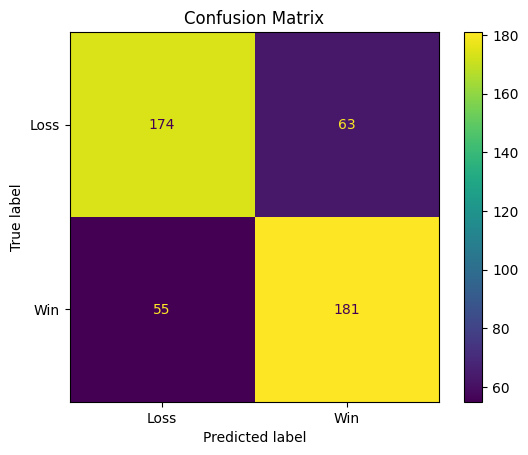

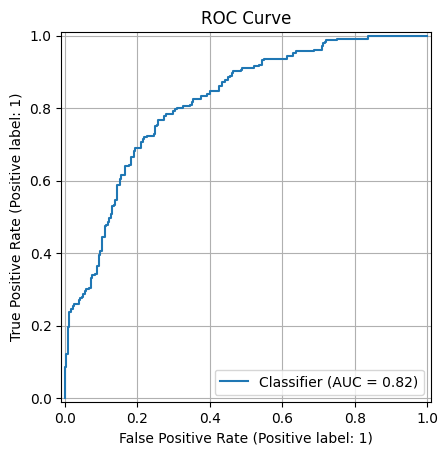

In [12]:
# ✅ Logistic Regression using multiple features

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# 1. Select input features and target
features = ["SeedDiff", "WinLossDiff", "MarginDiff", "PPGDiff", "PtsAllowedDiff"]
X = matchups[features]
y = matchups["Winner"]

# 2. Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# 4. Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("✅ Logistic Regression model trained")
print(f"📊 Accuracy: {accuracy:.4f}")
print(f"📈 AUC Score: {auc:.4f}")

# 5. Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Loss", "Win"])
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# 6. Plot ROC curve
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve")
plt.grid(True)
plt.show()


## Simulation Experiments
### Baseline Scenario

In this experiment, we apply the trained logistic regression model to all possible team matchups in the NCAA 2025 tournament. For each unique combination of TeamA vs TeamB, we compute the seed difference and use it to estimate the probability that TeamA wins. This baseline prediction scenario represents the system's output under ideal, unaltered input conditions.


In [14]:
from itertools import combinations
import numpy as np
import pandas as pd

# 1. Filter teams that qualified for the 2025 tournament
seeds_2025 = seeds[seeds["Season"] == 2025][["TeamID", "SeedNum", "Gender"]].copy()
team_stats_2025 = team_stats[team_stats["Season"] == 2025].copy()

# 2. Generate all possible matchups (TeamA ≠ TeamB)
baseline_rows = []
for gender in seeds_2025["Gender"].unique():
    teams = seeds_2025[seeds_2025["Gender"] == gender]["TeamID"].unique()

    for teamA, teamB in combinations(teams, 2):
        # Retrieve seed values
        sA = seeds_2025[(seeds_2025["TeamID"] == teamA) & (seeds_2025["Gender"] == gender)]["SeedNum"].values[0]
        sB = seeds_2025[(seeds_2025["TeamID"] == teamB) & (seeds_2025["Gender"] == gender)]["SeedNum"].values[0]

        # Retrieve team stats
        statsA = team_stats_2025[(team_stats_2025["TeamID"] == teamA) & (team_stats_2025["Gender"] == gender)]
        statsB = team_stats_2025[(team_stats_2025["TeamID"] == teamB) & (team_stats_2025["Gender"] == gender)]

        if statsA.empty or statsB.empty:
            continue  # Skip if data is missing

        # Compute input features
        row = {
            "Season": 2025,
            "Gender": gender,
            "TeamA": teamA,
            "TeamB": teamB,
            "SeedDiff": sB - sA,
            "WinLossDiff": statsA["WinLossRatio"].values[0] - statsB["WinLossRatio"].values[0],
            "MarginDiff": statsA["ScoringMargin"].values[0] - statsB["ScoringMargin"].values[0],
            "PPGDiff": statsA["AvgPointsScored"].values[0] - statsB["AvgPointsScored"].values[0],
            "PtsAllowedDiff": statsA["AvgPointsAllowed"].values[0] - statsB["AvgPointsAllowed"].values[0],
        }

        # Mirror the matchup (TeamB vs TeamA)
        row_mirror = row.copy()
        row_mirror["TeamA"] = teamB
        row_mirror["TeamB"] = teamA
        row_mirror["SeedDiff"] *= -1
        row_mirror["WinLossDiff"] *= -1
        row_mirror["MarginDiff"] *= -1
        row_mirror["PPGDiff"] *= -1
        row_mirror["PtsAllowedDiff"] *= -1

        baseline_rows.extend([row, row_mirror])

# 3. Create DataFrame with all matchups
baseline_df = pd.DataFrame(baseline_rows)

# 4. Predict win probabilities using the trained model
features = ["SeedDiff", "WinLossDiff", "MarginDiff", "PPGDiff", "PtsAllowedDiff"]
baseline_df["Pred"] = model.predict_proba(baseline_df[features])[:, 1]

# 5. Save to CSV
baseline_df.to_csv("Predictions/baseline_predictions_2025.csv", index=False)
print("✅ Baseline predictions saved to Predictions/baseline_predictions_2025.csv")
print("🔢 Total matchups:", len(baseline_df))


✅ Baseline predictions saved to Predictions/baseline_predictions_2025.csv
🔢 Total matchups: 9112


### Peturber Scenario

To simulate data uncertainty or measurement errors, we introduce random noise into the input feature `SeedDiff` from the 2025 tournament matchups.

The perturbation is a random value between ±2% and ±5% of the original seed difference. We then reapply the trained model to these noisy inputs to observe how sensitive the system is to small variations.


In [26]:
import numpy as np

# Make a copy of the baseline predictions
perturbed_df = matchups_2025_df.copy()

# Set random seed for reproducibility
np.random.seed(42)

# Generate random perturbation between ±2% and ±5% of abs(SeedDiff)
perturbation_pct = np.random.uniform(0.02, 0.05, size=len(perturbed_df))
perturbation_sign = np.random.choice([-1, 1], size=len(perturbed_df))
perturbation = perturbation_pct * perturbed_df["SeedDiff"].abs() * perturbation_sign

# Create a new column with perturbed values (for reference)
perturbed_df["PerturbedSeedDiff"] = perturbed_df["SeedDiff"] + perturbation

# Overwrite SeedDiff with perturbed values to match model input expectations
perturbed_df["SeedDiff"] = perturbed_df["PerturbedSeedDiff"]

# Predict using the trained model
perturbed_df["PerturbedPred"] = model.predict_proba(
    perturbed_df[["SeedDiff"]]
)[:, 1]

# Save perturbed prediction to Data folder
perturbed_df.to_csv("Data/perturbed_predictions_2025.csv", index=False)

# Preview result
perturbed_df[["TeamA", "TeamB", "PerturbedSeedDiff", "Pred", "PerturbedPred"]].head()


,TeamA,TeamB,PerturbedSeedDiff,Pred,PerturbedPred
0,1181,1104,1.031236,0.537314,0.538574
1,1104,1181,-1.048521,0.456373,0.454420
2,1181,1458,2.083920,0.577319,0.580638
3,1458,1181,-2.075920,0.416490,0.413500
4,1181,1112,2.925958,0.616335,0.613491


Average change in prediction: 0.0051
Matchups with >±0.10 change: 0.00%


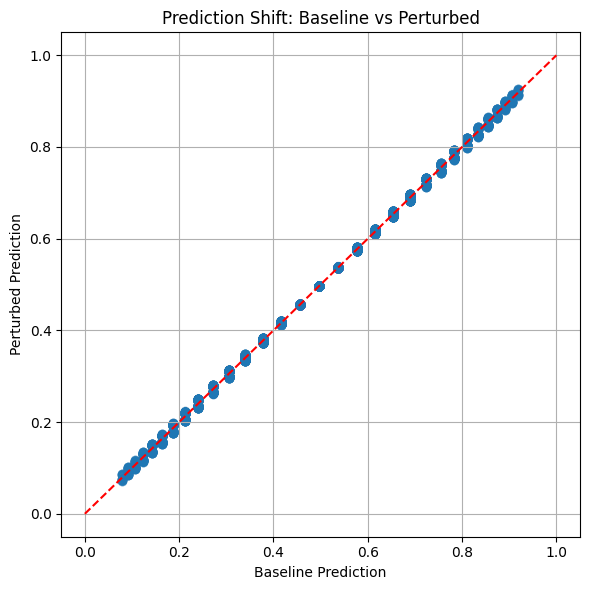

In [30]:
#!pip install matplotlib

import matplotlib.pyplot as plt

# Merge baseline and perturbed predictions
comparison_df = matchups_2025_df[["TeamA", "TeamB", "Pred"]].copy()
comparison_df["PerturbedPred"] = perturbed_df["PerturbedPred"]

# Calculate absolute difference
comparison_df["Delta"] = comparison_df["PerturbedPred"] - comparison_df["Pred"]
comparison_df["AbsDelta"] = comparison_df["Delta"].abs()

# Metrics
avg_change = comparison_df["AbsDelta"].mean()
shift_pct = (comparison_df["AbsDelta"] > 0.10).mean() * 100

print(f"Average change in prediction: {avg_change:.4f}")
print(f"Matchups with >±0.10 change: {shift_pct:.2f}%")

# Simple scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(comparison_df["Pred"], comparison_df["PerturbedPred"], alpha=0.3)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # identity line
plt.xlabel("Baseline Prediction")
plt.ylabel("Perturbed Prediction")
plt.title("Prediction Shift: Baseline vs Perturbed")
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
matchups_2025_df["Pred"].describe()

count    4556.000000
mean        0.497465
std         0.224899
min         0.079704
25%         0.304930
50%         0.496823
75%         0.689656
max         0.918411
Name: Pred, dtype: float64